# Metal Music Sampling

References: 

https://github.com/shubham3121/music-generation-using-rnn 

https://www.hackerearth.com/blog/developers/jazz-music-using-deep-learning/

https://pyguitarpro.readthedocs.io/en/stable/index.html

### Imports

In [37]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from tqdm import tqdm

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
from keras.utils import np_utils

### Play an example file

In [ ]:
# pip install pyguitarpro

In [2]:
SEQUENCE_LENGTH = 100

songs = glob('*.mid')

### PyGuitarPro / using tabulature

In [3]:
# TODO: Consider PyGuitarPro

import guitarpro

# PITCH[i] = the pitch associated with midi note number i.
# For example, PITCH[69] = 'A4'
PITCH = {val : str(guitarpro.GuitarString(number=0, value=val)) for val in range(128)}
# MIDI[string] = the midi number associated with the note described by string.
# For example, MIDI['A4'] = 69.
MIDI  = {str(guitarpro.GuitarString(number=0, value=val)) : val for val in range(128)}


'''
Make sure to convert every tab to 4/4 before pre-processing it, so that reconstruction works correctly.
'''

#demo = guitarpro.parse('deftones-be_quiet_and_drive.gp5')

#demo = guitarpro.parse('dream-theater-pull_me_under.gp5')

demo = guitarpro.parse('korn-blind.gp5')
#demo = guitarpro.parse('korn-chi.gp5')
#demo = guitarpro.parse('korn-falling_away_from_me.gp5')
#demo = guitarpro.parse('korn-freak_on_a_leash.gp5')
#demo = guitarpro.parse('korn-twist.gp5')

#demo = guitarpro.parse('mayhem-chainsaw_gutsfuck.gp4') # 5/4 time
#demo = guitarpro.parse('mayhem-deathcrush.gp4') # 5/4 time

#demo = guitarpro.parse('megadeth-wake_up_dead.gp5')

#demo = guitarpro.parse('metallica-enter_sandman.gp5')
#demo = guitarpro.parse('metallica-master_of_puppets.gp5')

#demo = guitarpro.parse('pantera-this_love.gp5')

#demo = guitarpro.parse('ratm-killing_in_the_name.gp5')

#demo = guitarpro.parse('sepultura-kaiowas.gp5') # 12/8 time
#demo = guitarpro.parse('sepultura-arise.gp5')

#demo = guitarpro.parse('slayer-raining_blood.gp5')
#demo = guitarpro.parse('slayer-seasons_in_the_abyss.gp5')
#demo = guitarpro.parse('slayer-south_of_heaven.gp5')

#demo = guitarpro.parse('slipknot-diluted.gp4')
#demo = guitarpro.parse('slipknot-people_=_shit.gp5')

#demo = guitarpro.parse('tool-schism.gp5')


for track in demo.tracks:
    print(track.name, track.channel.instrument)

Guitar - James Munky Shaffer 29
Guitar - Brian Head Welch 30
Distortion Overdub 30
Bass - Fieldy 36
Bass - Overdub 35
Bass Boom 79
Drums - David Silveria 0
Vocals - Johnathan Davis (Lyrics) 30


In [42]:
[track.name for track in demo.tracks if not track.isPercussionTrack]

['Guitar - James Munky Shaffer',
 'Guitar - Brian Head Welch',
 'Distortion Overdub',
 'Bass - Fieldy',
 'Bass - Overdub',
 'Bass Boom',
 'Vocals - Johnathan Davis (Lyrics)']

In [4]:
TRACK_TO_ANALYZE = 0

## Song Encoding (Compression)

In [5]:
from guitarpro import Note, NoteType
    


def process_notes(beat, tuning):
    
    duration = (beat.duration.value, beat.duration.isDotted)
    
    # Tuplets are cool but rare.
    # If a tuplet is found, simply halve its play time (by doubling its duration value) to simplify things.
    if beat.duration.tuplet.enters != 1 or beat.duration.tuplet.times != 1:
        duration = (duration[0] * 2, duration[1]) # Tuples aren't mutable, so just re-assign the tuple.
    
    if len(beat.notes) == 0:
        return 'rest', duration[0], duration[1]
    
    note_types = [note.type for note in beat.notes]

    
    if all(note_type == NoteType.rest for note_type in note_types):
        return 'rest', duration[0], duration[1]
    
    if all(note_type == NoteType.tie for note_type in note_types):
        return 'tied', duration[0], duration[1]
    
    if all(note_type == NoteType.dead for note_type in note_types):
        return 'dead', duration[0], duration[1]
    
    # note_number = MIDI note number, where A4 = 440 Hz = note 69
    # pitches = np.array([note.value + tuning[note.string] if note.type == NoteType.normal else np.nan for note in beat.notes])
    pitches = np.array([note.value + tuning[note.string] for note in beat.notes if note.type == NoteType.normal])
    pitches = pitches[~np.isnan(pitches)]
    
    
    # Pitches are often stored in descending order, but we want to make sure they're in ascending order.
    # Thus, we flip the pitches before sorting, so as to help the algorithm.
    pitches = np.sort(pitches[::-1]) 
    
    if len(pitches) == 0:
        return 'rest', duration[0], duration[1]
    
    if len(pitches) == 1:
        return PITCH[pitches[0]], duration[0], duration[1]
    
    # Look at the pitch intervals in the lowest 3 notes that are being played.
    # Usually, chords will start at the lowest 2 notes.
    # However, sometimes players will strum the open lowest string constantly throughout the song.
    # (see: 'Be Quiet and Drive', 'Kaiowas')
    # Thus, the next-highest pair of notes should be considered when labeling a chord.
    if len(pitches) == 2:
        note_pairs = [(0, 1)]
    if len(pitches) == 3:
        note_pairs = [(0, 1), (0, 2), (1, 2)]
    elif len(pitches) >= 4:
        note_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
        
    for idx1, idx2 in note_pairs:

        interval = pitches[idx2] - pitches[idx1]
        
        if interval == 12 or interval == 7:
            # Return a power chord associated with pitches[idx1]
            return PITCH[pitches[idx1]] + '_5', duration[0], duration[1]

        if interval == 6:
            # Return a tritone chord associated with pitches[idx1]
            return PITCH[pitches[idx1]] + '_dim5', duration[0], duration[1]
        
    
    return PITCH[pitches[0]], duration[0], duration[1]

In [6]:
# All tabs should have the same number of measures,
# so let's just take the number of measures in the first track
length = len(demo.tracks[1].measures)

song = np.empty(length, dtype=object)


track = demo.tracks[TRACK_TO_ANALYZE]
tuning = {string.number : string.value for string in track.strings}
lowest_string = len(tuning) # Bass = 4 strings, while metal guitars = 6 - 8 strings.

print(f'Tuning = {[PITCH[x] for x in tuning.values()]}')

for m_i, measure in enumerate(track.measures):
    
    
    '''
    Upon inspection of some of the most popular Songsterr .gp5 tabs,
    it turns out that each measure always has two Voices.
    The first Voice (index 0) always contains music, while
    the second Voice (index 1) always just contains an empty Beat with no notes.

    Therefore, only the first Voice (index 0) actually matters.
    '''
    song[m_i] = np.empty(len(measure.voices[0].beats), dtype=object)
    
    #print(m_i+1)
    for b_i, beat in enumerate(measure.voices[0].beats):
        song[m_i][b_i] = process_notes(beat, tuning)
        #print('\t', song[m_i][b_i], '\t', beat.duration)

Tuning = ['D4', 'A3', 'F3', 'C3', 'G2', 'D2', 'A1']


## Song Decoding (Reconstruction)

In [7]:
def get_strings(chord, tuning):
    
    lowest_string = len(tuning) # Bass has 4 strings, while metal guitars can have 6-8 strings.
    
    chord_parts = chord.split('_')
    
    root_value = MIDI[chord_parts[0]]
    
    if root_value < tuning[lowest_string]:
        # TODO: send an Exception instead of just a print()
        print('!!!!! error !!!!!\t', root_value, ' ', tuning[lowest_string], ' ', tuning, ' ', lowest_string)
    
    # Using the tuning, get a list of all possible fret positions for the root note.
    tuning_values = np.array(list(tuning.values()))
    fingerings = root_value - tuning_values
    
    
    # + 1 because tuning[] is 1-indexed.
    string = np.where(fingerings >= 0, fingerings, np.inf).argmin() + 1
    fret = fingerings[string-1]
    
    # If we are just playing a single note, then the function can just return what it has now.
    if len(chord_parts) == 1:
        return [(fret, string)]
    
    # If the chord requires a very high pitch, lower its fingering to the second-highest string,
    # so as to save the highest string for the other part of the chord.
    if string == 1:
        string = 2
        fret = fingerings[string-1]
    
    if chord_parts[1] == '5':
        upper_value = root_value + 7 # perfect fifth
    elif chord_parts[1] == 'dim5':
        upper_value = root_value + 6 # tritone
    else:
        upper_value = root_value + 5 # in case of an error, assume that the upper value is a perfect 4th above the root.
    
    
    upper_fret = upper_value - tuning[string-1]
    if upper_fret < 0:
        # There are some rare cases where the chord cannot be played given a tuning.
        # For example, a tritone or a perfect 4th with root C2 in a drop-C guitar.
        # In that case, just return the root note.
        return [(fret, string)]
    
    return [(fret, string), (upper_fret, string-1)]

In [8]:
from guitarpro import Measure, MeasureHeader, Beat, Duration, GuitarString


# TODO: Eventually, I may have to choose a tempo (default 120) by learning a different classifier.
#       For now, I can assume that I have the tempo given.

new_song = guitarpro.models.Song()

# Set the guitar tuning for the instrument.

# TODO: Eventually, I'll have to choose the tuning based on the lowest note of the generated sequence.
#       For now, I can assume that I have the tuning given.
new_song.tracks[0].strings = [GuitarString(number=num, value=val) for num, val in tuning.items()]
new_song.tracks[0].strings


# The first measureHeader and measure are already added by default.
for i in range(1, len(song)):
    start = guitarpro.Duration.quarterTime * (1 + i*6)

    new_song.addMeasureHeader(MeasureHeader(number=i+1, start=start))
    new_song.tracks[0].measures.append( Measure(new_song.tracks[0], new_song.measureHeaders[i]) )



    

for m_i, measure in enumerate(new_song.tracks[0].measures):
    
    # "beats" starts off as an empy array [].
    voice = measure.voices[0]
    beats = voice.beats
    
    #print(m_i+1)
    # For the m_i-th measure, get the indices b_i and the beats song_beat of the compressed song.
    for b_i, song_beat in enumerate(song[m_i]):
        
        # TODO: Implement chords after implementing single notes on lowest frets.
        chord = song_beat[0]
        duration = Duration(value=song_beat[1], isDotted=song_beat[2])
        
        # since "beats" is empty, we can append Beat objects to it.
        beats.append(Beat(voice, duration=duration))
        if chord == 'rest':
            beats[b_i].status = guitarpro.BeatStatus.rest
            
        elif chord == 'tied':
            if b_i == 0:
                # Get the last Beat object from the previous Measure.
                previous_beat = new_song.tracks[0].measures[m_i-1].voices[0].beats[-1]
            else:
                # Get the previous Beat object from the current Measure.
                previous_beat = beats[b_i-1]
                
            for note in previous_beat.notes:
                beats[b_i].notes.append(Note(beat=beats[b_i], value=note.value, string=note.string, type=NoteType.tie))
                
            
               
            
        elif chord == 'dead':
            beats[b_i].notes.append(Note(beat=beats[b_i], value=0, string=lowest_string, type=NoteType.dead))
            beats[b_i].notes.append(Note(beat=beats[b_i], value=0, string=lowest_string-1, type=NoteType.dead))
            beats[b_i].notes.append(Note(beat=beats[b_i], value=0, string=lowest_string-2, type=NoteType.dead))
            
        else:
            for fret, string in get_strings(chord, tuning):
                beats[b_i].notes.append(Note(beat=beats[b_i], value=fret, string=string))
            
        
        #print('\t', chord, '\t', duration)
            
            
# Lastly, save the song to a .gp5 file.
guitarpro.write(new_song, '_new_song.gp5')
print(demo.title + ' reconstruction is finished')

Blind reconstruction is finished


## Song Vectorization

#### get_notes()

In [9]:
# Store all notes from all songs as a one-dimensional vector of tuples.

# This was originally in get_notes(), which returned the 'notes' object.

notes = np.zeros(np.sum([len(measure) for measure in song]), dtype=object)

note_idx = 0
for m_idx, measure in enumerate(song):
    for b_idx, beat in enumerate(measure):
        notes[note_idx] = beat
        note_idx += 1
        
with open('data/notes', 'wb') as filepath:
    pickle.dump(notes, filepath)
        
print(f'Number of notes:\t {len(notes)}')
print(f'Number of unique notes:\t {len(set(notes))}')

Number of notes:	 958
Number of unique notes:	 37


#### prepare_sequences(notes, n_vocab)

In [33]:
# The function originally returned (network_input, network_output).

n_vocab = len(set(notes))
# ^ originally a parameter of the function


# def prepare_sequences(notes, n_vocab):

# Create a dictionary to map notes to integers
note_to_int = dict((note, number) for number, note in enumerate(set(notes)))
int_to_note = {v: k for k, v in note_to_int.items()} # Invert the map

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - SEQUENCE_LENGTH, 1):
    sequence_in = notes[i: i + SEQUENCE_LENGTH]
    sequence_out = notes[i + SEQUENCE_LENGTH]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# reshape the input into a format comatible with LSTM layers 
network_input = np.reshape(network_input, (n_patterns, SEQUENCE_LENGTH, 1))

# normalize input
network_input = network_input / float(n_vocab)

# one hot encode the output vectors
network_output = np_utils.to_categorical(network_output)

print('Input and output processed.')

Input and output processed.


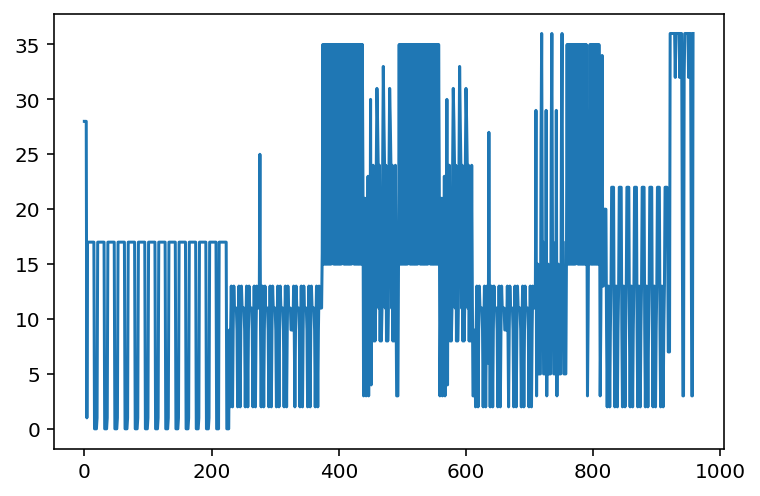

In [38]:
plt.plot([note_to_int[x] for x in notes])

In [11]:
def create_network(network_in, n_vocab): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(128, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [12]:
def train(model, network_input, network_output, epochs): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'weights.best.music3.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=32, callbacks=[checkpoint])

In [13]:
n_vocab = len(set(notes))
print(f'Vocab generated = {n_vocab} notes.')

#network_in, network_out = prepare_sequences(notes, n_vocab)
#print('Input and Output processed')

Vocab generated = 37 notes.


In [ ]:
#epochs = 200 # 200 caused runtime disconnection
epochs = 150

model = create_network(network_input, n_vocab)
print('Model created')

#return model

print('Training in progress')
train(model, network_input, network_output, epochs)
print('Training completed')

## Note generation

In [16]:
def get_inputSequences(notes, note_to_int, n_vocab):
    """ Prepare the sequences used by the Neural Network """

    generation_input = []
    for i in range(0, len(notes) - SEQUENCE_LENGTH, 1):
        sequence_in = notes[i:i + SEQUENCE_LENGTH]
        generation_input.append([note_to_int[char] for char in sequence_in])
    
    generation_input = np.reshape(generation_input, (len(generation_input), SEQUENCE_LENGTH, 1))
    
    return (generation_input)

In [17]:
def generate_notes(model, network_input, note_to_int, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # Pick a random integer
    start = np.random.randint(0, len(network_input)-1)

    # Invert the note_to_int dictionary to get the int_to_note dictionary.
    int_to_note = inv_map = {v: k for k, v in note_to_int.items()}
    
    # pick a random sequence from the input as a starting point for the prediction
    pattern = list(network_input[start])
    prediction_output = []
    
    print('Generating notes........')

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        # Predicted output is the argmax(P(h|D))
        index = np.argmax(prediction)
        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)

        pattern.append(np.array([index])) # Fixed this code to make sure the new element matched the datatype of the existing elements.
        # Next input to the model
        pattern = pattern[1:len(pattern)]

    print('Notes Generated.')
    return prediction_output

In [18]:
""" Generate a .gp5 tab file """

'''
#load the notes used to train the model
with open('data/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))
'''

print('Initiating music generation process.......')

#network_input = get_inputSequences(notes, pitchnames, n_vocab)
generation_input = get_inputSequences(notes, note_to_int, n_vocab)

normalized_input = generation_input / float(n_vocab)
model = create_network(normalized_input, n_vocab)
print('Loading Model weights.....')
model.load_weights('weights.best.music3.hdf5')
print('Model Loaded')
prediction_output = generate_notes(model, generation_input, note_to_int, n_vocab)

Initiating music generation process.......
Loading Model weights.....
Model Loaded
Generating notes........
Notes Generated.


In [19]:
def thirty_seconds_to_duration(count):
    if count % 3 == 0:
        # If the note is dotted, do 32 / (i * 2/3), and return isDotted = True.
        return (48//count, True)
    else:
        # If the note is not dotted, to 32 / i, and return isDotted = False.
        return (32//count, False)

def quantize_thirty_seconds(value):

    # 32nd-note values of each fundamental type of note (not including 64th-notes, of course).
    vals = np.array([32, # whole
                     24, # dotted half
                     16, # half
                     12, # dotted quarter
                     8,  # quarter
                     6,  # dotted eigth
                     4,  # eigth
                     3,  # dotted sixteenth
                     2,  # sixteenth
                     1]) # thirty-second
    
    list_out = []

    for v in vals:
        if v <= value:
            list_out.append(thirty_seconds_to_duration(v))
            value -= v
            
    return np.array(list_out)

#### Adjust prediction output to 4/4 time

In [20]:
# This will be the prediction output
new_prediction_output = []


time = 0
for beat in prediction_output:
    
    # Calculate the fraction of a measure encompassed by the current beat / chord.
    beat_time = (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    # Calculate the fraction of a measure taken up by all notes in the measure.
    # Calculate any residual time to see if this measure (in 4/4 time) is longer than 1 measure.
    measure_time = time + beat_time
    leftover_time = (measure_time) % 1
    
    # If the measure count (i.e., the measure integer) has changed and there is significant left-over beat time:
    if (int(measure_time) > int(time)) and (leftover_time > 1/128):
        
        # Calculate the initial 32nd notes encompassed by this beat in the current measure.
        this_measure_thirty_seconds = int(32 * (1 - time % 1))
        # Calculate the remaining 32nd notes encompassed by this beat in the next measure.
        next_measure_thirty_seconds = int(32 * leftover_time)
        
        # Get the Duration object parameters for this measure and the next measure.
        this_measure_durations = quantize_thirty_seconds(this_measure_thirty_seconds)
        next_measure_durations = quantize_thirty_seconds(next_measure_thirty_seconds)
        
        
        #print(f'{{ {32 / beat[1]}')
        for duration_idx, duration in enumerate(this_measure_durations):
            time += (1 / duration[0]) * (1 + 0.5 * duration[1])
            
            #print(time, '\t', time * 32)
                
            chord = beat[0] if duration_idx == 0 else 'tied'
            
            new_prediction_output.append((chord, duration[0], duration[1]))
            
            
        for duration in next_measure_durations:
            time += (1 / duration[0]) * (1 + 0.5 * duration[1])
            
            #print(time, '\t', time * 32)
            
            new_prediction_output.append(('tied', duration[0], duration[1]))
            
               
        continue
    
    
    time += beat_time
    new_prediction_output.append((beat[0], beat[1], beat[2]))
    
    #print(time, '\t', time * 32)


'''
time = 0
time2 = 0
idx = 0

for idx2, beat2 in enumerate(new_prediction_output[:100]):
    beat = prediction_output[idx]
    
    if time == time2:
        print(beat[0], '\t', time, '\t\t', beat2[0], '\t', time2)
        
        idx += 1
        
        time += (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    else:
        print('\t\t\t\t', beat2[0], '\t', time2)

    
    
    time2 += (1 / beat2[1]) * (1 + 0.5 * beat2[2])
''';

#### Separate prediction output notes into measures

In [21]:
# Use the previously calculated cumulative time as the number of measures in the new 4/4 song.
num_measures = int(np.ceil(time))

song = np.empty(num_measures, dtype=object)

time = 0
m_idx = 0

timestamps = []

for beat in new_prediction_output:
    #print(time)
    timestamps.append(time)
    
    m_idx = int(time)
    
    if song[m_idx] is None:
        
        song[m_idx] = [beat]
    else:
        song[m_idx].append(beat)
    
    
    time += (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    
print(f'4/4 adjusted correctly: {set(range(num_measures)).issubset(set(timestamps))}')

4/4 adjusted correctly: True


#### Figure out the necessary guitar tuning for the produced song

In [31]:
# Get the tuning (i.e., the lowest note) of the song:

pitchnames = set([x[0] for x in prediction_output])
pitchnames.discard('rest')
pitchnames.discard('tied')
pitchnames.discard('dead')


standard_tuning = {1: MIDI['E4'],
                   2: MIDI['B3'],
                   3: MIDI['G3'],
                   4: MIDI['D3'],
                   5: MIDI['A2'],
                   6: MIDI['E2']}

# Get the lowest note in the output.
# The highest tuning allowed will be standard tuning.
lowest_note = min([MIDI[x.split('_')[0]] for x in pitchnames])
lowest_note = min(lowest_note, MIDI['E2'])

if lowest_note <= MIDI['B1']:
    # 7-string guitar case
    tuning[7] = MIDI['B1']
    drop = MIDI['B1'] - lowest_note
else:
    # drop the tuning by however much is necessary.
    drop = MIDI['E2'] - lowest_note
    
tuning = {k: v - drop for k, v in tuning.items()}
tuning

{1: 64, 2: 59, 3: 55, 4: 50, 5: 45, 6: 40, 7: 35}

#### Store the song as a tab

In [32]:
from guitarpro import Measure, MeasureHeader, Beat, Duration, GuitarString

PRINT = False

# TODO: Eventually, I may have to choose a tempo (default 120) by learning a different classifier.
#       For now, I can assume that I have the tempo given.

generation = guitarpro.models.Song()

# Set the guitar tuning for the instrument.

# TODO: Eventually, I'll have to choose the tuning based on the lowest note of the generated sequence.
#       For now, I can assume that I have the tuning given.
generation.tracks[0].strings = [GuitarString(number=num, value=val) for num, val in tuning.items()]
generation.tracks[0].strings


# The first measureHeader and measure are already added by default.
for i in range(1, len(song)):
    start = guitarpro.Duration.quarterTime * (1 + i*6)

    generation.addMeasureHeader(MeasureHeader(number=i+1, start=start))
    generation.tracks[0].measures.append( Measure(generation.tracks[0], generation.measureHeaders[i]) )



    

for m_i, measure in enumerate(generation.tracks[0].measures):
    
    # "beats" starts off as an empy array [].
    voice = measure.voices[0]
    beats = voice.beats
    
    if PRINT:
        print(m_i+1)
    # For the m_i-th measure, get the indices b_i and the beats song_beat of the compressed song.
    for b_i, song_beat in enumerate(song[m_i]):
        
        # TODO: Implement chords after implementing single notes on lowest frets.
        chord = song_beat[0]
        val = np.int32(song_beat[1])
        val = val.item()
        #duration = Duration(value=val, isDotted=bool(song_beat[2]))
        duration = Duration(value=8)
        # since "beats" is empty, we can append Beat objects to it.
        beats.append(Beat(voice, duration=duration))
        if chord == 'rest':
            beats[b_i].status = guitarpro.BeatStatus.rest
            
        elif chord == 'tied':
            if b_i == 0:
                # Get the last Beat object from the previous Measure.
                previous_beat = generation.tracks[0].measures[m_i-1].voices[0].beats[-1]
            else:
                # Get the previous Beat object from the current Measure.
                previous_beat = beats[b_i-1]
                
            for note in previous_beat.notes:
                beats[b_i].notes.append(Note(beat=beats[b_i], value=note.value, string=note.string, type=NoteType.tie))
                
            
               
            
        elif chord == 'dead':
            beats[b_i].notes.append(Note(beat=beats[b_i], value=0, string=lowest_string, type=NoteType.dead))
            beats[b_i].notes.append(Note(beat=beats[b_i], value=0, string=lowest_string-1, type=NoteType.dead))
            beats[b_i].notes.append(Note(beat=beats[b_i], value=0, string=lowest_string-2, type=NoteType.dead))
            
        else:
            for fret, string in get_strings(chord, tuning):
                beats[b_i].notes.append(Note(beat=beats[b_i], value=fret, string=string))
            
        if PRINT:
            print('\t', chord, '\t', duration)
            
            
# Lastly, save the song to a .gp5 file.
guitarpro.write(generation, '_generation.gp5')
print('Generation is finished')

'''
TODO: Preliminary data exploration before training:
- frequency of (chord, duration) pairs in dataset
- frequency of (chord, duration) pairs in generated output
- exclusively korn songs in low registers
- Less 'chuggy' songs
- Clean up this code!!
''';

Generation is finished
